In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.MStorch import MultiSlice, LARBED, SED
from src.util import toCPU, toGPU, device, SimulationCell
from wfRead import readPhaseGrating, wfRead


using cuda:0
using torch.float32


In [2]:
! zmult64 110_P.ms -output 1


 ELECTRON DIFFRACTION BY MULTISLICE METHOD
 J.M. ZUO, UIUC, 2005 and modified 2007 & 2008

 Input file : 110_P.ms    
  
 Title : _sf _file _cor _new _abs
  
 INPUT FLAGS:
  
 FILE (1 to use file for atomic coords) :            1
 XYZ  (1 to use xyz format) :            0
 NEW  (1 to use input without dw) :            1
 ABS  (1 to include mean absorption) :            1
 COR  (1 to include C5 and other aberr) :            1
 SF   (1 to use default table) :            1
 AUTO (1 to use autoslice) :            0
 PAR  (1 to read a list of TEM parameters) :            1

 THE 2-D CELL OF THE DIRECT SPACE IS DEFINED BY 
        a =    103.90583
        b =    100.54134
    gamma =  90.00000
    caxis = 386.69748

  Number of Atoms :       196115
  

 THERE ARE   196115 ATOMS IN THE CELL, THEY ARE
  1  0.117390  0.904786  0.538090 1.0000
  1  0.380350  0.098088  0.583333 1.0000
  1  0.131930  0.922939  0.619683 1.0000
  1  0.593319  0.597975  0.652243 1.0000
  1  0.657462  0.423111  0.681

In [3]:
si_pg = np.fromfile(r'test\Si\Si110_20x14x50.img', dtype=np.complex64, offset=8).reshape(-1,1024,1024)#[:,256:768,256:768]
# si_pg = readPhaseGrating(r'temp.pg', (1024, 1024), 200)
simCell = SimulationCell(1024, 1024, 108.6, 107.5088, 90.0000)
probe = toGPU(wfRead('probe.wf')[0][0])
# probe = torch.ones((1024,1024), dtype=torch.complex64, device=device)
# i,j = np.mgrid[-3:4,-3:4]
# beams = tuple(zip(i.flatten(), j.flatten()))
sed = SED(simulationCell=simCell,
          zStep=7.6792/4,
          nSlice=200, 
          nStep=(24,17), 
          scanSize=(0.050000, 0.0714285/2), 
          kV=300, 
          potential=toGPU(si_pg), 
          tilt=(0,0)
         ).to(device)

c:\Users\hcni2\.conda\envs\torch\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
sed.nStep

(17, 24)

In [5]:
sim = sed.simulate(probe.T)

(0, 0)
(0, 2)
(0, 4)
(0, 6)
(0, 9)
(0, 11)
(0, 13)
(0, 15)
(0, 17)
(0, 19)
(0, 21)
(0, 23)
(0, 26)
(0, 28)
(0, 30)
(0, 32)
(0, 34)
(0, 36)
(0, 38)
(0, 41)
(0, 43)
(0, 45)
(0, 47)
(0, 49)
(2, 0)
(2, 2)
(2, 4)
(2, 6)
(2, 9)
(2, 11)
(2, 13)
(2, 15)
(2, 17)
(2, 19)
(2, 21)
(2, 23)
(2, 26)
(2, 28)
(2, 30)
(2, 32)
(2, 34)
(2, 36)
(2, 38)
(2, 41)
(2, 43)
(2, 45)
(2, 47)
(2, 49)
(4, 0)
(4, 2)
(4, 4)
(4, 6)
(4, 9)
(4, 11)
(4, 13)
(4, 15)
(4, 17)
(4, 19)
(4, 21)
(4, 23)
(4, 26)
(4, 28)
(4, 30)
(4, 32)
(4, 34)
(4, 36)
(4, 38)
(4, 41)
(4, 43)
(4, 45)
(4, 47)
(4, 49)
(6, 0)
(6, 2)
(6, 4)
(6, 6)
(6, 9)
(6, 11)
(6, 13)
(6, 15)
(6, 17)
(6, 19)
(6, 21)
(6, 23)
(6, 26)
(6, 28)
(6, 30)
(6, 32)
(6, 34)
(6, 36)
(6, 38)
(6, 41)
(6, 43)
(6, 45)
(6, 47)
(6, 49)
(9, 0)
(9, 2)
(9, 4)
(9, 6)
(9, 9)
(9, 11)
(9, 13)
(9, 15)
(9, 17)
(9, 19)
(9, 21)
(9, 23)
(9, 26)
(9, 28)
(9, 30)
(9, 32)
(9, 34)
(9, 36)
(9, 38)
(9, 41)
(9, 43)
(9, 45)
(9, 47)
(9, 49)
(11, 0)
(11, 2)
(11, 4)
(11, 6)
(11, 9)
(11, 11)
(11, 13)
(11, 15

In [6]:
simCPU = toCPU(sim)


In [6]:
simCPU.shape

(17, 24, 1024, 1024)

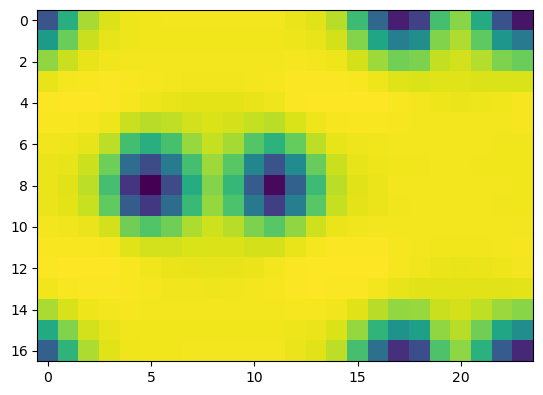

In [7]:
plt.imshow(np.sum(simCPU, axis=(2,3)))

In [7]:
%matplotlib qt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(simCPU[0, 0], cmap='gray')
ax.axis('off')

def update(frame):
    i = frame // 24
    j = frame % 24
    im.set_array(simCPU[i, j, 256:768, 256:768])
    return [im]

ani = FuncAnimation(fig, update, frames=17*24, blit=True)
plt.show()

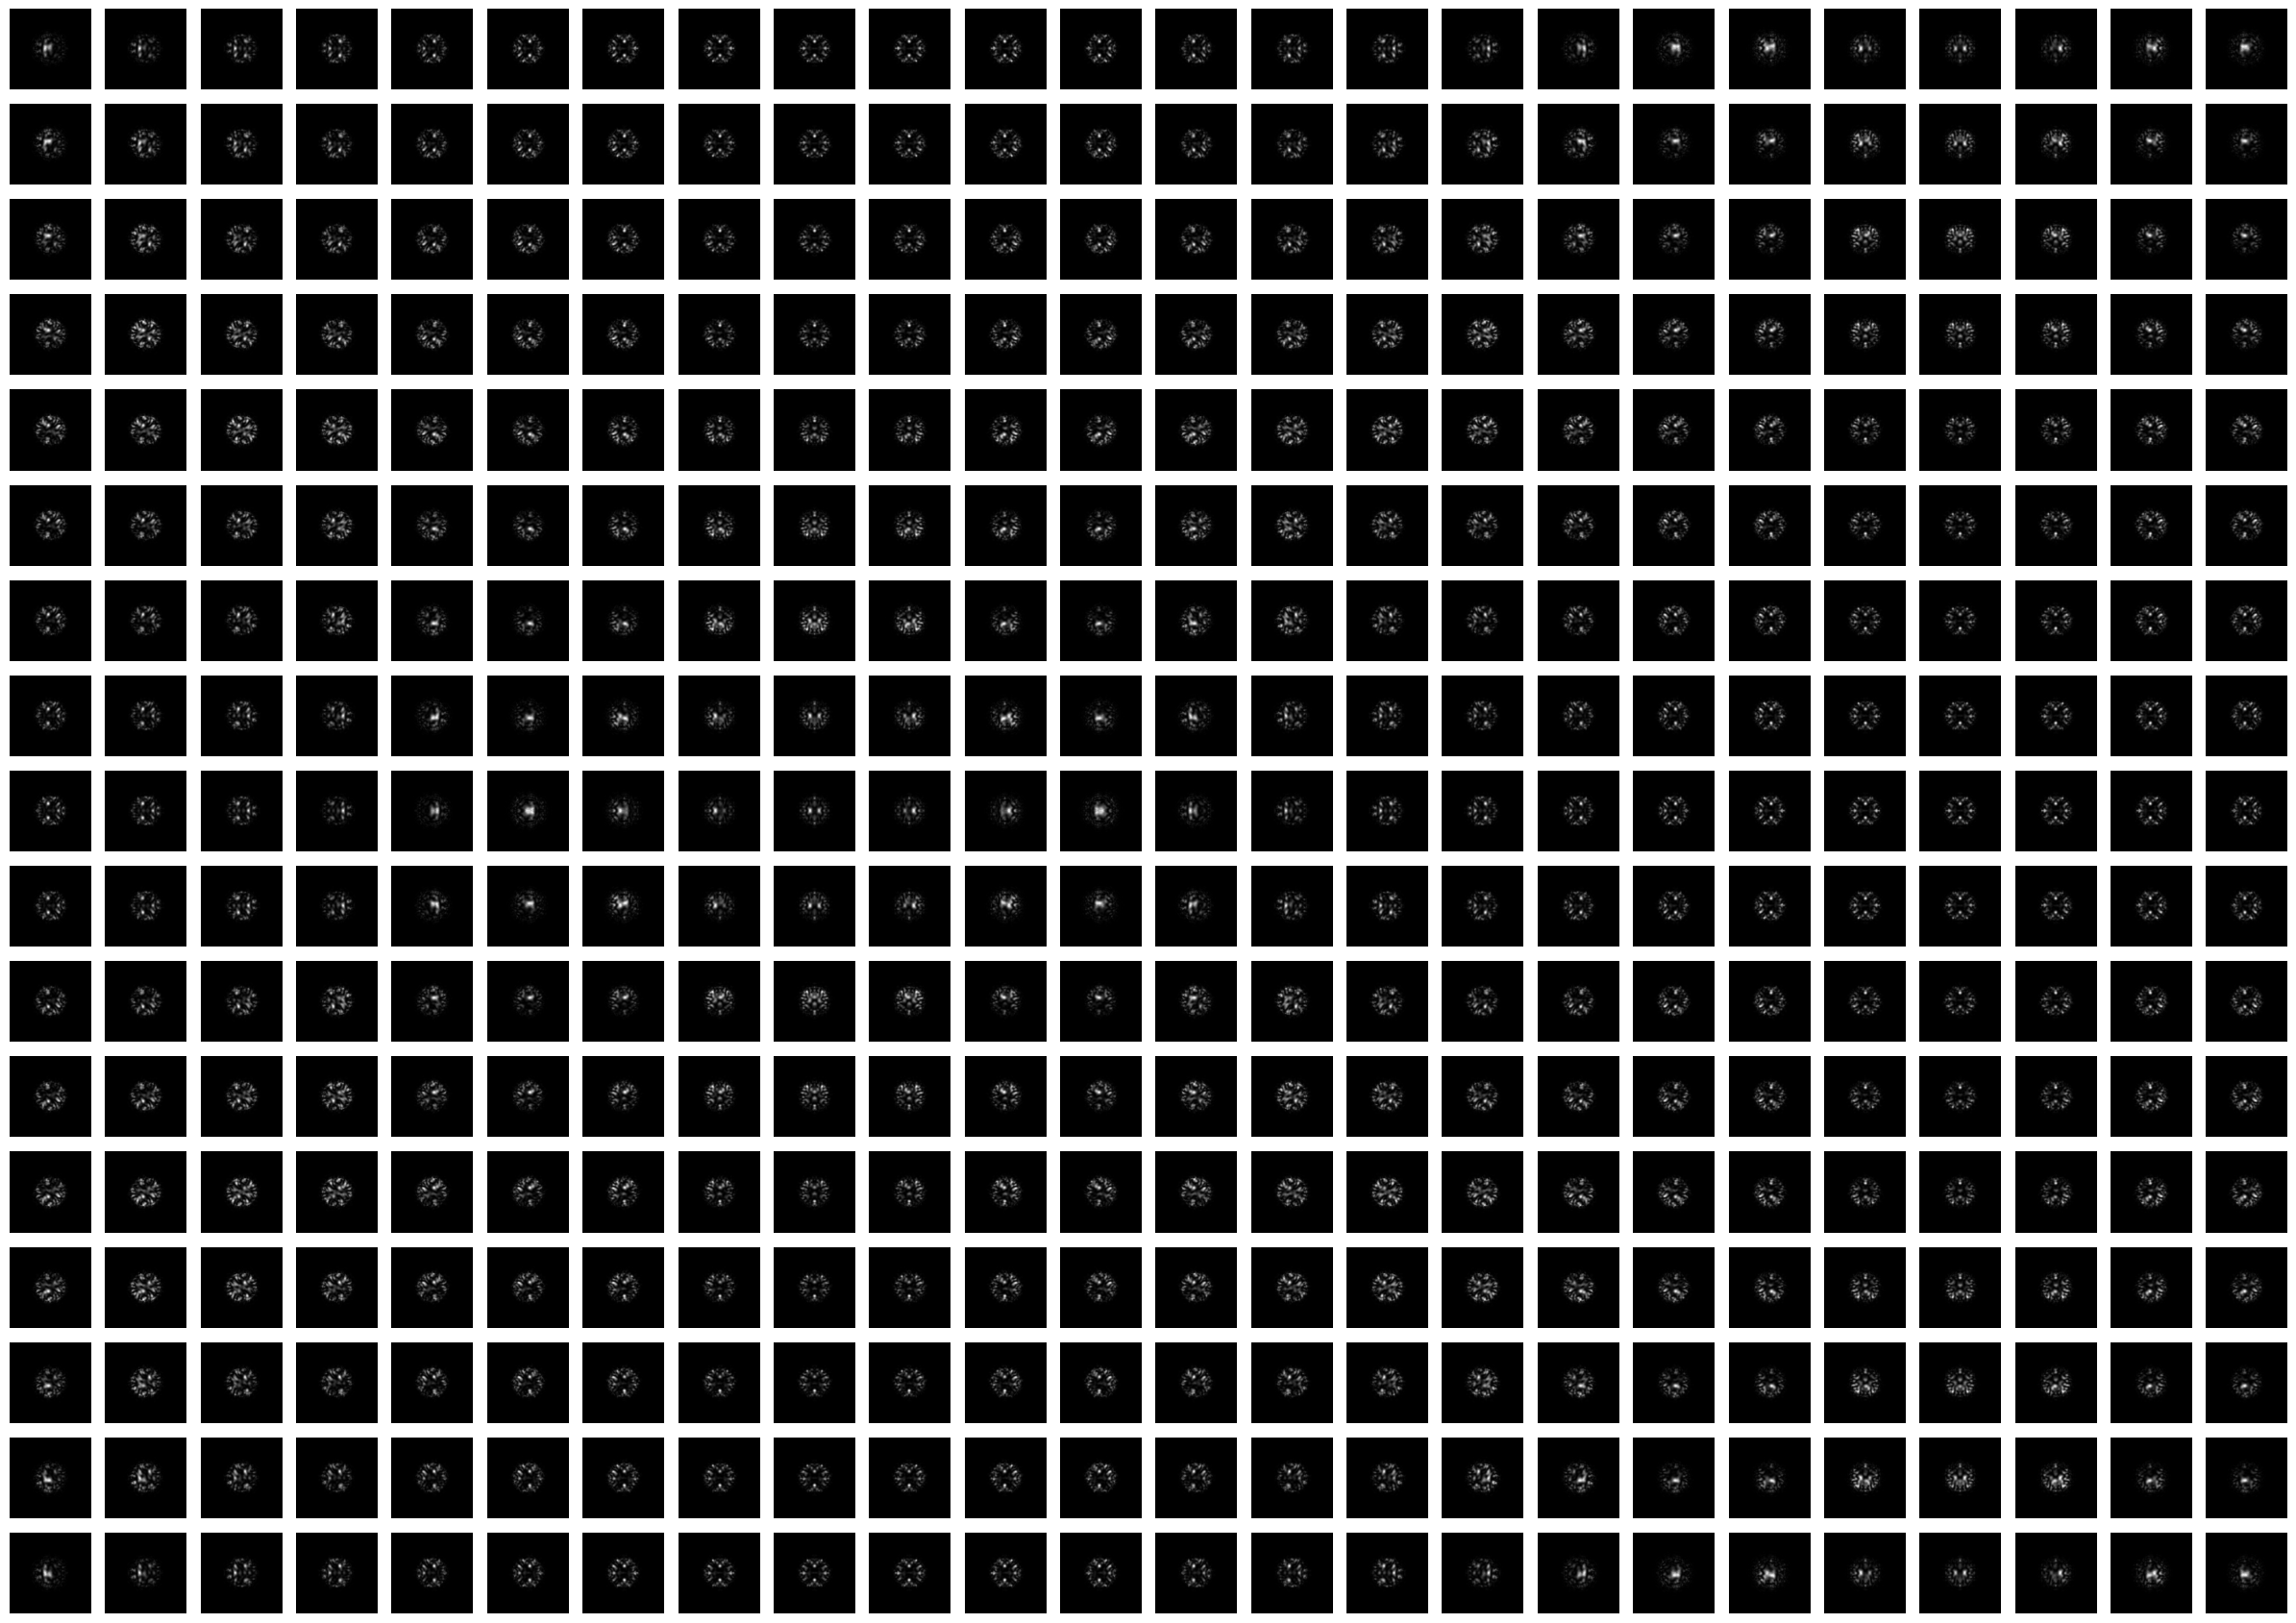

In [8]:
fig, axes = plt.subplots(17, 24, figsize=(24, 17))
for i in range(17):
    for j in range(24):
        ax = axes[i, j]
        ax.imshow(simCPU[i, j, 256:768, 256:768], cmap='gray')
        ax.axis('off')
plt.tight_layout()
plt.show()